<a href="https://colab.research.google.com/github/ttogle918/classify_instrument_by_CNN/blob/master/audio_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CycleGAN 튜토리얼 : https://www.tensorflow.org/tutorials/generative/cyclegan?hl=ko <br/>

CQT 변환에 대하여 : https://hyunlee103.tistory.com/41

TimbreTron 

1(그랜드 피아노) -> 25(어쿠스틱 기타)

1(그랜드 피아노) -> 68(바리톤 색소폰)


In [1]:
import numpy as np
import pandas as pd
import pickle

C:\Users\ttogl\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ttogl\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ttogl\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
pickle_path = "pickle"

In [3]:
# checkpoint 불러오기 ( 저장된 파일 확인 )
with open(pickle_path + "/audio_df_01_spt.pickle", "rb") as f:
    spt = pickle.load(f)
with open(pickle_path + '/audio_df_01_ins.pickle', 'rb') as f:
    ins = pickle.load(f)
# with open(path + '/audio_df_01_note_list.pickle', 'rb') as f:
#     note_list = pickle.load(f)

In [4]:
len(spt), len(ins), len(set(ins))#, len(set(note_list))

(19200, 19200, 128)

### Scaler : MinMaxScaler 변형
최솟값 : -1, 최댓값 1<br/>
이상치에 취약하다는 단점이 있다.

-> 데이터 분포도 봐야하나..?

### 데이터셋 나누기

In [5]:
ins_piano = []
ins_guitar = []
ins_sax = []

for i in range(len(ins)) :
  if ins[i] == 1 :
    ins_piano.append(i)
  
  if ins[i] == 25 :
    ins_guitar.append(i)

  if ins[i] == 68 :
    ins_sax.append(i)

train_piano = [spt[i] for i in ins_piano]
train_guitar = [spt[i] for i in ins_guitar]
# train_sax = [spt[i] for i in ins_sax]

# len(train_piano), len(train_guitar), len(train_sax)
len(train_piano), len(train_piano[0]), len(train_piano[0][0])

(150, 168, 87)

In [6]:
from sklearn.model_selection import train_test_split
train_piano = np.array(train_piano)
train_guitar = np.array(train_guitar)
# train_sax = np.array(train_sax)

train_piano, test_piano, train_guitar, test_guitar = train_test_split(train_piano, train_guitar, test_size=0.2) # spt로 ins 추측

In [ ]:
# !pip install git+https://github.com/tensorflow/examples.git
# !pip install -U tfds-nightly
# !pip install tensorflow_datasets
# !pip install tensorflow_addons
!pip install h5py==2.7

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE
# Define the standard image size.
orig_img_size = (286, 286)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 1)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1

AttributeError: type object 'h5py.h5.H5PYConfig' has no attribute '__reduce_cython__'

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 1])
  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  # scaling
  spt_max = np.max(image)
  spt_min = np.min(image)
  spt_mid = (spt_max + spt_min) / 2

  image = (image - spt_mid) / (spt_max - spt_min) * 2  # -1 ~ 1

  image = tf.cast(image, tf.float32)
  print("normalize : ",image.shape)
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 1
  image = tf.image.resize(image.reshape(image.shape[0], image.shape[1], 1), [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 1
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(images):
  new_tf = []

  for i, image in enumerate(images) :
    image = random_jitter(image)  # tf.image
    new_tf.append(image)

    # images = random_jitter(images)  # tf.image
  new_tf = np.array(new_tf)
  print(len(new_tf))
  new_tf = normalize(new_tf)
  print(new_tf.shape)
  return new_tf

In [ ]:
def preprocess_image_test(image):
  image = normalize(image)
  return image

In [11]:
print(type(train_piano), len(train_piano))
train_piano = preprocess_image_train(train_piano)
train_guitar = preprocess_image_train(train_guitar)

test_piano = preprocess_image_train(test_piano)
test_guitar = preprocess_image_train(test_guitar)

# for data in train_piano :
#   preprocess_image_train(data)


# train_guitar = preprocess_image_train(train_guitar)

# test_piano = preprocess_image_test(test_piano)
# test_guitar = preprocess_image_test(test_guitar)

# train_horses = train_horses.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

# train_zebras = train_zebras.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

# test_horses = test_horses.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

# test_zebras = test_zebras.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

<class 'numpy.ndarray'> 120


NameError: name 'preprocess_image_train' is not defined

In [16]:
sample_piano = next(iter(train_piano))
sample_zebra = next(iter(train_guitar))

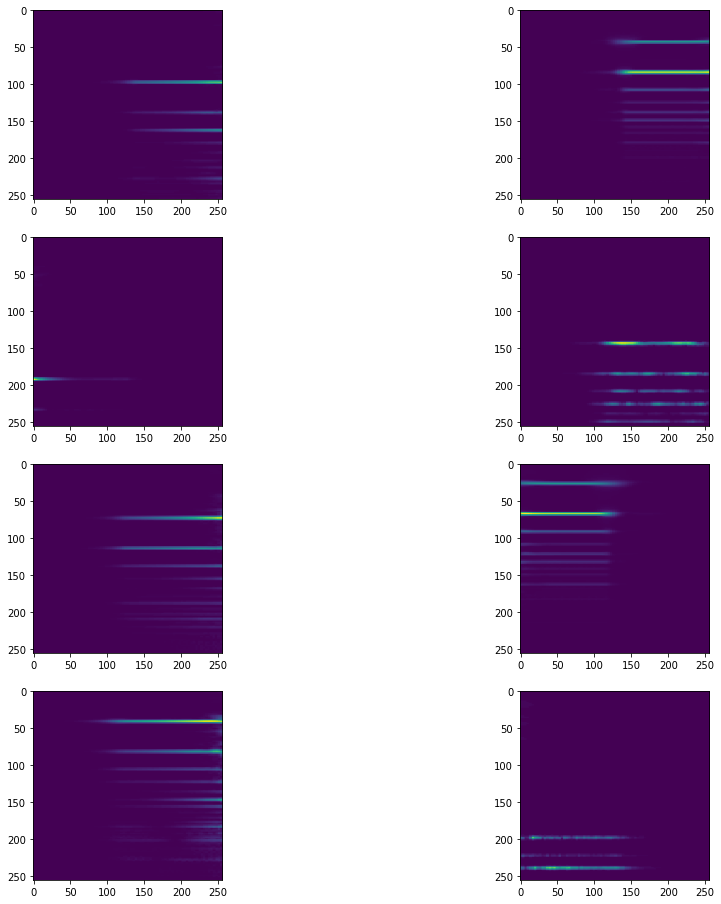

In [17]:
_, ax = plt.subplots(4, 2, figsize=(16, 16))
for i, samples in enumerate(zip(train_piano[0:4], train_guitar[0:4])):
    piano = np.array((samples[0][:,:,0] * 127.5) + 127.5).astype(np.uint8)
    guitar = np.array((samples[1][:,:,0] * 127.5) + 127.5).astype(np.uint8)
    ax[i, 0].imshow(piano)  # imshow는 (s1, s2, 3) : RGB 혹은 (s1, s2) : 흑백 둘 중 하나 출력한다.
    ax[i, 1].imshow(guitar)
plt.show()

빌더 모델?

In [18]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(x, activation, kernel_initializer=kernel_init, kernel_size=(3, 3), strides=(1, 1), padding="valid", gamma_initializer=gamma_init, use_bias=False,):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, use_bias=use_bias,)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, use_bias=use_bias,)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(x, filters, activation, kernel_initializer=kernel_init, kernel_size=(3, 3), strides=(2, 2), padding="same", gamma_initializer=gamma_init, use_bias=False,):
    x = layers.Conv2D(filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, use_bias=use_bias,)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def upsample(x, filters, activation, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init, gamma_initializer=gamma_init, use_bias=False,):
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, use_bias=use_bias, )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [19]:
def get_resnet_generator(filters=64, num_downsampling_blocks=2, num_residual_blocks=9, num_upsample_blocks=2, gamma_initializer=gamma_init, name=None,):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")  # shape == (None, 256, 256, 1)
    print("img_input :",img_input.shape)
    x = ReflectionPadding2D(padding=(3, 3))(img_input) # 256  + 3 * 2    # (None, 262, 262, 1)
    
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(x) # filters : 64
    print(x.shape)  # shape == (None, 256, 256, 64)

    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    print(x.shape)

    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    print(x.shape)

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))
    print(x.shape)

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))
    print(x.shape)

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(1, (7, 7), padding="valid")(x)   #
    x = layers.Activation("tanh")(x)

    print(x.shape)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [20]:
def get_discriminator(filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None) :
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(filters, (4, 4), padding="same", kernel_initializer=kernel_initializer)(img_input)  # ?
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 0:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(2, 2), )  # ?
        else:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(1, 1), )

    x = layers.Conv2D(1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer)(x)
    print(x.shape)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

img_input : (None, 256, 256, 1)
(None, 256, 256, 64)
(None, 256, 256, 64)
(None, 64, 64, 256)
(None, 64, 64, 256)
(None, 256, 256, 64)
(None, 256, 256, 1)
img_input : (None, 256, 256, 1)
(None, 256, 256, 64)
(None, 256, 256, 64)
(None, 64, 64, 256)
(None, 64, 64, 256)
(None, 256, 256, 64)
(None, 256, 256, 1)
(None, 256, 256, 1)
(None, 256, 256, 1)


In [21]:
class CycleGan(keras.Model):
    def __init__(self, generator_G, generator_F, discriminator_X, discriminator_Y, lambda_cycle=10.0, lambda_identity=0.5, ) :
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(self, gen_G_optimizer, gen_F_optimizer, disc_X_optimizer, disc_Y_optimizer, gen_loss_fn, disc_loss_fn, ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is piano and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different kinds of losses for the generators and discriminators.
        # 생성자와 판별자의 로스를 다른 방식으로 계산해야한다.
        # We will perform the following steps here:
        # 우리는 다음과 같은 단계로 수행한다.
        # 1. Pass real images through the generators and get the generated images
        # 1. 실제 이미지를 생성자로 통과시키고, 생성된 이미지를 얻는다.
        # 2. Pass the generated images back to the generators to check if we can predict the original image from the generated image.
        #   2. 생성된 이미지로 원본 이미지를 예측할 수 있는지 생성자에게 확인한다?
        # 3. Do an identity mapping of the real images using the generators.
        #   3. 실제 이미지를 생성자를 사용하며 확인한다.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        #   4. 대응하는 판별자에게 생성된 이미지를 보낸다.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        #   5. 생성자의 전체 로스를 계산한다.
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 7. 생성자의 가중치를 갱신한다.
        # 8. Update the weights of the discriminators
        # 8. 판별자의 가중치를 갱신한다.
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # piano to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake piano -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (piano to fake zebra to fake piano): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake piano to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [22]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=5):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(5, 2, figsize=(12, 12))
        for i, img in enumerate(test_piano.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

In [23]:
tf.data.Dataset.from_tensors(train_piano)

<TensorDataset shapes: (120, 256, 256, 1), types: tf.float32>

In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
# Train the model for just one epoch only using 150 images
cycle_gan_model.fit(tf.data.Dataset.zip((tf.data.Dataset.from_tensors(train_piano), tf.data.Dataset.from_tensors(train_guitar))), epochs=1, callbacks=plotter,)

In [ ]:
# ??
!curl -LO https://github.com/AakashKumarNain/CycleGAN_TF2/releases/download/v1.0/saved_checkpoints.zip
!unzip -qq saved_checkpoints.zip

In [ ]:
# Load the checkpoints
weight_file = "./saved_checkpoints/cyclegan_checkpoints.090"
cycle_gan_model.load_weights(weight_file).expect_partial()
print("Weights loaded successfully")

_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(test_piano.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

### Pix2Pix 모델 가져오기 및 재사용하기


In [ ]:
OUTPUT_CHANNELS = 1

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
to_zebra = generator_g(sample_piano)
to_piano= generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_piano, to_zebra, sample_zebra, to_piano]
title = ['Piano', 'To Zebra', 'Zebra', 'To Piano']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real piano?')
plt.imshow(discriminator_x(sample_piano)[0, ..., -1], cmap='RdBu_r')

plt.show()

### 손실 함수

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### 체크포인트

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

### Train

In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_piano, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_piano) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_piano)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

### test dataset을 사용하여 생성

In [ ]:
# Run the trained model on the test dataset
for inp in test_piano.take(5):
  generate_images(generator_g, inp)